<a href="https://colab.research.google.com/github/cloudmrhub/cloudmr-tools/blob/main/cloudmr_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Cloudmr Tools — Notebook Guide

> **Purpose**: This notebook demonstrates how to install **cloudmr-tools**, load example MRI k‑space/noise data, and run common 2D reconstructions (RSS, B1, SENSE, GRAPPA).


## Repro/Environment

- Python ≥ 3.9 recommended


In [1]:
!pip install git+https://github.com/cloudmrhub/cloudmr-tools

  Cloning https://github.com/cloudmrhub/cloudmr-tools to /tmp/pip-req-build-w9ubqjhn
  Running command git clone --filter=blob:none --quiet https://github.com/cloudmrhub/cloudmr-tools /tmp/pip-req-build-w9ubqjhn
  Resolved https://github.com/cloudmrhub/cloudmr-tools to commit aab46ed8e67413c9d8f3f9b23b371cc12be8a87e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/erosmontin/pyable.git to /tmp/pip-install-yl96xdkc/pyable-eros-montin_38a7f1644726415b9fd36f158cb5d80a
  Running command git clone --filter=blob:none --quiet https://github.com/erosmontin/pyable.git /tmp/pip-install-yl96xdkc/pyable-eros-montin_38a7f1644726415b9fd36f158cb5d80a
  Resolved https://github.com/erosmontin/pyable.git to commit 4cd2b95f5352c165a1a59c187033f1eb6cec00f4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  C

['/usr/local/lib/python3.12/dist-packages/cmtools']


Text(0.5, 0, 'Phase Encoding')

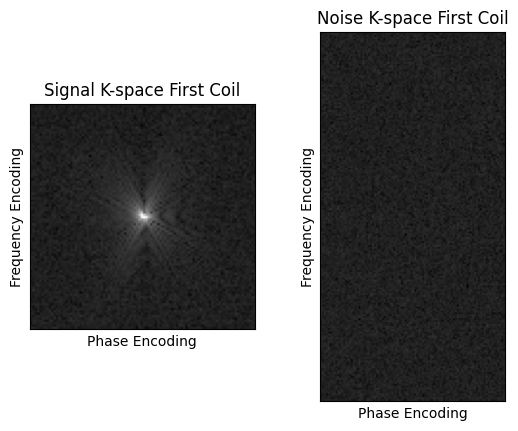

In [17]:
# Load the data available for testing
from pynico_eros_montin import pynico as pn

import numpy as np
import matplotlib.pyplot as plt

import cmtools
import os
import importlib.util
import warnings
warnings.filterwarnings("ignore")
# get the data
spec = importlib.util.find_spec('cmtools')
print(spec.submodule_search_locations)
if spec is not None:
    package_path = spec.submodule_search_locations[0]
    package_path=os.path.join(package_path,'testdata.pkl')
else:
    print("cmtools module not found")

a=pn.Pathable(package_path)
A=a.readPkl()
S=A[0]["signal"]
N=A[0]["noise"]
from matplotlib.colors import PowerNorm
gamma_value = 0.35
norm = PowerNorm(gamma=gamma_value)

import matplotlib.pyplot as plt
plt.figure()
plt.subplot(121)
plt.imshow(np.abs(S[:,:,0]), cmap='gray',norm=norm)
plt.title('Signal K-space First Coil')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.ylabel('Frequency Encoding')
plt.xlabel('Phase Encoding')
plt.subplot(122)

plt.imshow(np.abs(N[:,:,0]), cmap='gray',norm=norm)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('Noise K-space First Coil')
plt.ylabel('Frequency Encoding')
plt.xlabel('Phase Encoding')



# Root Sum of Squares Reconstruction

Text(0.5, 1.0, 'RSS Reconstruction')

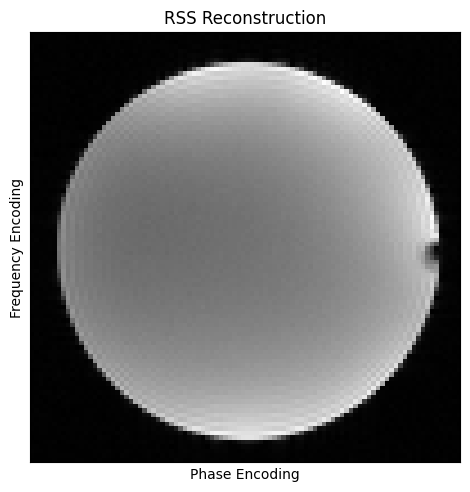

In [11]:

from cmtools.cm2D import cm2DReconRSS

L=cm2DReconRSS()
L.setNoiseKSpace(N)
L.setSignalKSpace(S)
OUT=L.getOutput()

#plotting
plt.figure()
plt.imshow(np.abs(OUT), cmap='gray')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.ylabel('Frequency Encoding')
plt.xlabel('Phase Encoding')
plt.tight_layout()
plt.title('RSS Reconstruction')




# Noise Covariance and prewhitening

Text(0.5, 1.0, 'Original K-space First Coil')

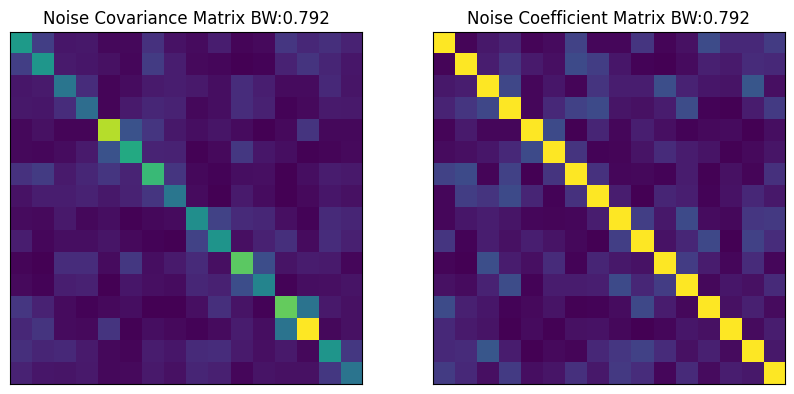

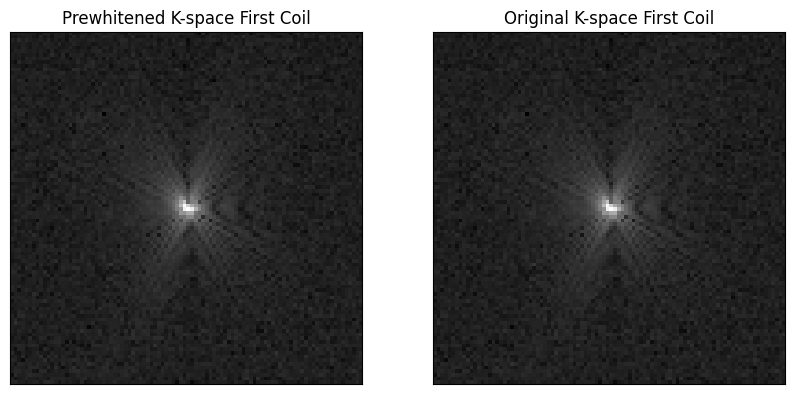

In [20]:
from logging import warning
from cmtools.cm2D import cm2DReconRSS, cm2DReconB1,cm2DReconSENSE,cm2DGFactorSENSE,cm2DReconGRAPPA
import cmtools.cm as cm

L=cm2DReconRSS()
L.setSignalKSpace(S)
L.setNoiseKSpace(N)

NBW=L.getNoiseBandWidth()

NC=L.getNoiseCovariance()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.abs(NC))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

plt.title(f'Noise Covariance Matrix BW:{NBW:.3f}')

plt.subplot(122)
plt.imshow(np.abs(L.getNoiseCovarianceCoefficients()))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

plt.title(f'Noise Coefficient Matrix BW:{NBW:.3f}')


p=L.getPrewhitenedSignal()
plt.figure(figsize=(10,5))
plt.subplot(121)
norm2 = PowerNorm(gamma=0.35)
plt.imshow(np.abs(p[:,:,0]), cmap='gray',norm=norm2)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

plt.title('Prewhitened K-space First Coil')

plt.subplot(122)
plt.imshow(np.abs(S[:,:,0]), cmap='gray',norm=norm)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('Original K-space First Coil')



# Coil Sensitivity Maps

calculateCoilsSensitivityMask2D reference 


Text(0.5, 1.0, 'B1 Reconstruction')

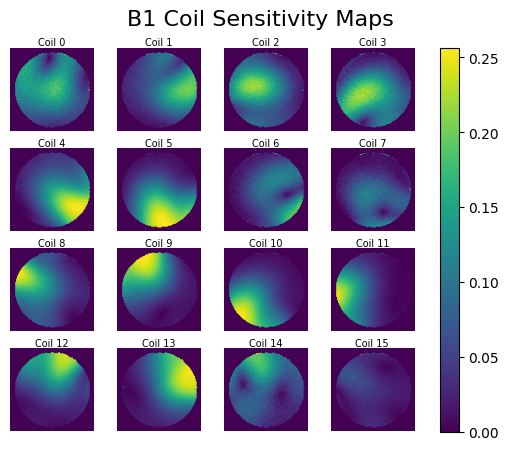

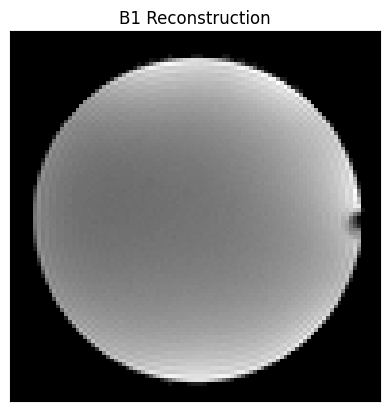

In [22]:
L=cm2DReconB1()
L.setSignalKSpace(S)
L.setNoiseKSpace(N)
L.setReferenceKSpace(S)
L.prepareCoilSensitivityMatrixPlot(title='B1 Coil Sensitivity Maps')
plt.figure()
plt.imshow(np.abs(L.getOutput()), cmap='gray')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('B1 Reconstruction')



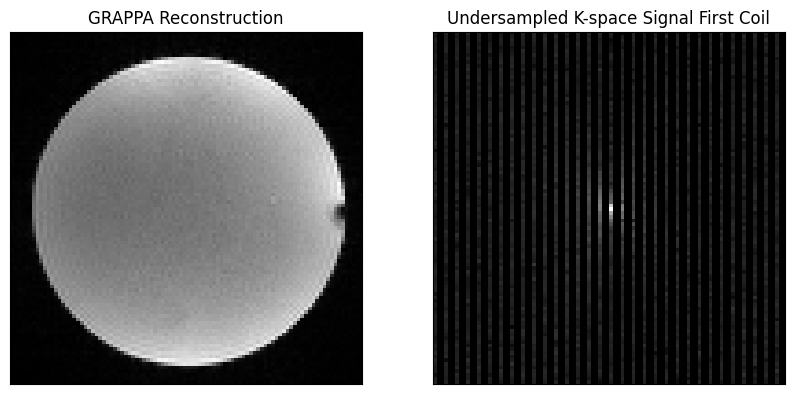

In [26]:

FA=1
PA=3
ACLF=24
ACLP=24
GK=[4,5]

US,REF=cm.mimicAcceleration2D(S,[FA,PA],[ACLF,ACLP])
L=cm2DReconGRAPPA()
L.setSignalKSpace(US)
L.setAcceleration([FA,PA])
L.setAutocalibrationLines([ACLF,ACLP])
L.setNoiseKSpace(N)
L.setGRAPPAKernel(GK)
L.setReferenceKSpace(REF)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.abs(L.getOutput()), cmap='gray')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

plt.title('GRAPPA Reconstruction')

plt.subplot(122)
plt.imshow(np.abs(US[:,:,0]), cmap='gray',norm=norm)
plt.title('Undersampled K-space Signal First Coil')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.show()



calculateCoilsSensitivityMask2D reference 
(96, 96, 16)


Text(0.5, 1.0, 'Mask')

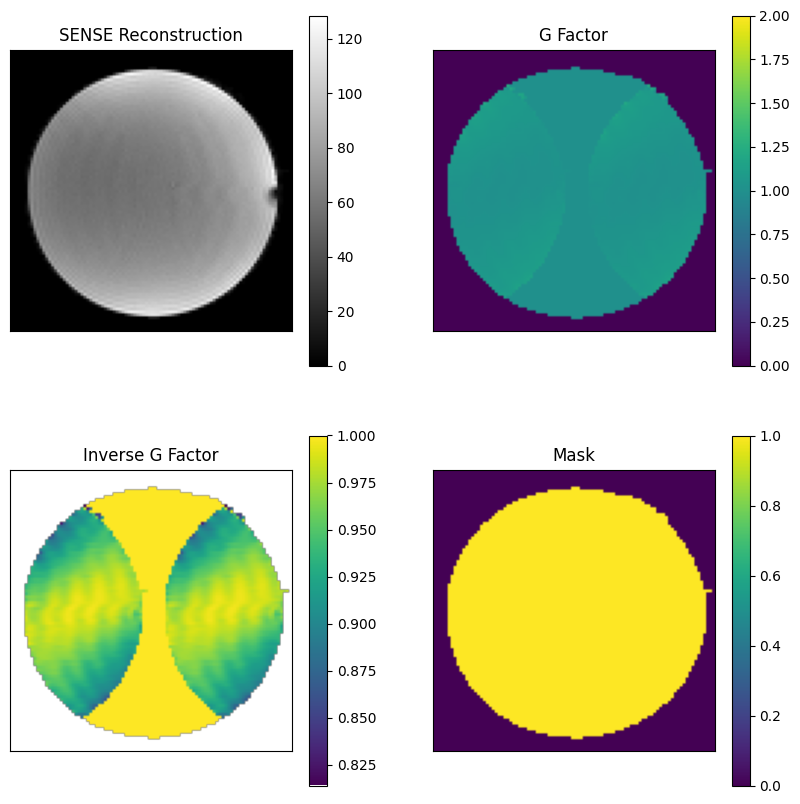

In [24]:
# Acceleration frequency and phase
FA=1
PA=2
# Autocalibration lines
ACL=24
L=cm2DReconSENSE()
L.setAcceleration([FA,PA])
US,REF=cm.mimicAcceleration2D(S,[FA,PA],ACL=[np.nan,ACL])

L.setSignalKSpace(US)
L.setNoiseKSpace(N)
L.setReferenceKSpace(REF)
L.setAutocalibrationLines(ACL)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.abs(L.getOutput()), cmap='gray')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('SENSE Reconstruction')
plt.colorbar()



L.__class__=cm2DGFactorSENSE
plt.subplot(222)
G=L.getOutput()
plt.imshow(np.abs(G),vmin=0,vmax=2)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.colorbar()
plt.title('G Factor')

iG=1.0/G
iG[np.isnan(iG)]=0
plt.subplot(223)
plt.imshow(iG)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.colorbar()
plt.title('Inverse G Factor')


A=L.outputMask.get()
print(A.shape)
plt.subplot(224)
plt.imshow(A[:,:,0])
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.colorbar()
plt.title('Mask')



Text(0.5, 1.0, 'My New Reconstruction')

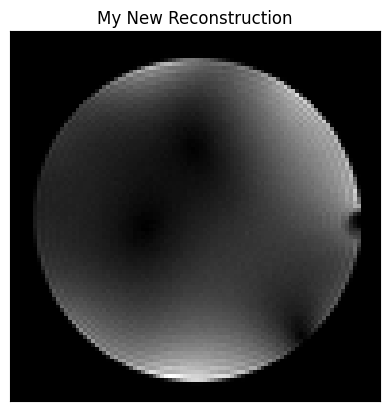

In [27]:
from cmtools.cm2D import cm2DReconRSS

class cm2DRecon2(cm2DReconRSS):

    def getOutput(self):
        img_matrix = self.get2DKSIFFT()
        im = np.sum(img_matrix**2,axis=-1)
        return im


RSS2=cm2DRecon2()
RSS2.setSignalKSpace(S)
RSS2.setNoiseKSpace(N)
IM=RSS2.getOutput()
plt.figure()
plt.imshow(np.abs(IM), cmap='gray')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('My New Reconstruction')
